# Perceptrón Multicapa

Como modelo simple para ir aprendiendo el uso de PyTorch vamos a crear un perceptrón multicapa y entrenarlo con los datos en bruto.

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
%reload_ext autoreload

import pandas as pd
import torch
import matplotlib.pyplot as plt
import repackage
repackage.up()

from utils import *
from fluxdataset import *

In [2]:
PATH = "../datos/"
TRAIN_FILE = "exoTrain.csv"
TEST_FILE = "exoTest.csv"

In [4]:
#leemos los datos de ambos datasets
df_train_raw = pd.read_csv(f'{PATH}{TRAIN_FILE}', low_memory=False)
df_test_raw = pd.read_csv(f'{PATH}{TEST_FILE}', low_memory=False)
train_x, train_y = generate_x_y_df(df_train_raw)
train_y = train_y.add(-1) #pasamos de 1-2 a 0-1

In [5]:
train_x.shape, train_y.shape

((5087, 3197), (5087,))

In [101]:
#definicion del modelo
class Perceptron(torch.nn.Module):
    #definimos la estructura de la red
    #capa de entrada x con activacion relu
    #capa oculta con activacion relu
    #capa de salida con activacion softmax
    def __init__(self, n_features, n_hidden):
        super(Perceptron, self).__init__()
        self.fully_connected_1 = torch.nn.Linear(n_features, n_hidden)
        self.fully_connected_2 = torch.nn.Linear(n_hidden, n_hidden)
        self.fully_connected_3 = torch.nn.Linear(n_hidden, 2)
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax(dim = 1)
        #self.softmax = torch.nn.Sigmoid()
        
    #definimos el flujo 
    def forward(self, x):
        x = self.relu(self.fully_connected_1(x))
        x = self.relu(self.fully_connected_2(x))
        x = self.softmax(self.fully_connected_3(x))
        #x = self.fully_connected_3(x)
        return x

In [102]:
learning_rate = 0.01
epochs = 50
train_x_tensor = torch.tensor(train_x.values).float()
train_y_tensor = torch.tensor(train_y.values)

In [103]:
#instanciamos nuestro modelo
modelo = Perceptron(n_features = train_x.shape[1], n_hidden = 300) 

In [104]:
optimizer = torch.optim.SGD(modelo.parameters(), lr = learning_rate)
loss_function = torch.nn.CrossEntropyLoss()

In [105]:
for epoch in range(epochs):
    #limpiamos los gradientes
    optimizer.zero_grad()
    #propagamos la entrada hacia delante
    predictions = modelo(train_x_tensor)
    #calculamos la perdida
    loss = loss_function(predictions.squeeze(), train_y_tensor)
    #ejecutamos back-propagation
    loss.backward()
    #actualizamos los pesos
    optimizer.step()
    #imprimimos
    if epoch % 10 == 0:
        print('Epoch: {} loss: {}'.format(epoch, loss.item()))
        
print('Epoch: {} loss: {}'.format(epochs, loss.item()))

Epoch: 0 loss: 0.6825169920921326
Epoch: 10 loss: 0.3248158395290375
Epoch: 20 loss: 0.32400718331336975
Epoch: 30 loss: 0.32347506284713745
Epoch: 40 loss: 0.3230949342250824
Epoch: 50 loss: 0.32283318042755127


In [106]:
predictions

tensor([[1.0000e+00, 1.7377e-37],
        [1.0000e+00, 1.4737e-18],
        [1.0000e+00, 0.0000e+00],
        ...,
        [1.0000e+00, 1.1166e-15],
        [9.9553e-01, 4.4728e-03],
        [1.0000e+00, 1.0477e-15]], grad_fn=<SoftmaxBackward>)

Como sospechabamos, sin hacer ningun tratamiento previo a los datos, el modelo solamente devuelve que no existe exoplaneta con certeza absoluta en practicamente todos los casos.

## Preparando los datos

- normalizar
- eliminar picos de luz

In [42]:
df_train = pd.read_csv(f'{PATH}{TRAIN_FILE}', low_memory=False)
df_test = pd.read_csv(f'{PATH}{TEST_FILE}', low_memory=False)

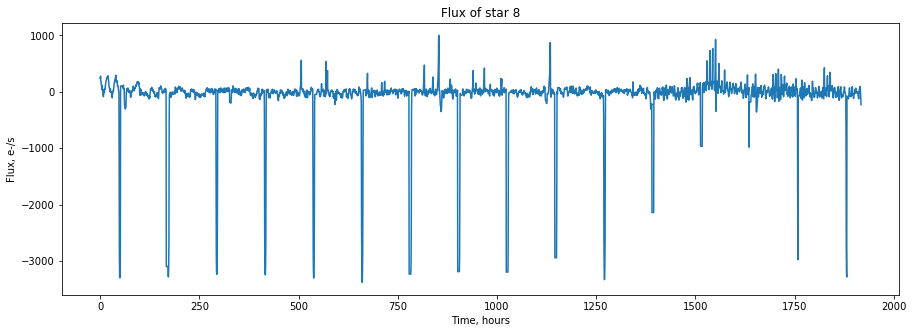

In [43]:
show_flux_plot(df_train.drop('LABEL', axis = 1), [7])

In [44]:
df_train.iloc[:, 1:] = reduce_upper_outliers(df_train.iloc[:, 1:], 0.01)
df_train = z_score_normalizing(df_train)

Vemos como queda tras quitar los picos de intensidad

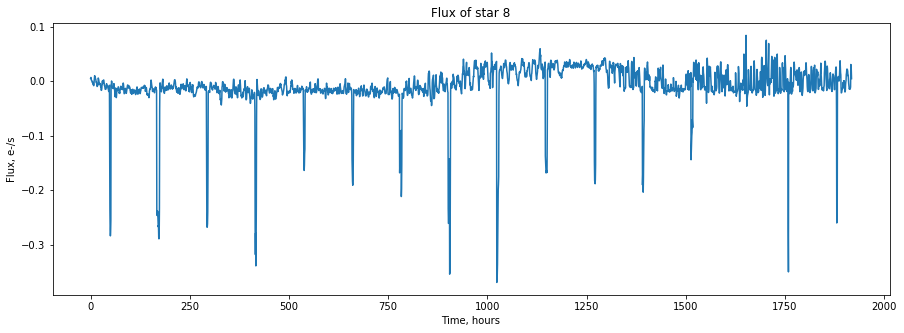

In [45]:
show_flux_plot(df_train.drop('LABEL', axis = 1), [7])

In [46]:
df_train['LABEL'] = df_train['LABEL'].add(-1)
validation_proportion = 0.2
df_train, df_validation = split_train_df(df_train, validation_proportion)
df_validation = df_validation.sample(frac=1) 

In [47]:
class Perceptron(torch.nn.Module):
    def __init__(self):
        super(Perceptron, self).__init__()
        self.fc1 = torch.nn.Linear(3197, 1000)
        self.fc2 = torch.nn.Linear(1000, 250)
        self.fc3 = torch.nn.Linear(250, 20)
        self.fc4 = torch.nn.Linear(20, 2)
        self.relu = torch.nn.ReLU()
        #self.logsoftmax = torch.nn.LogSoftmax(dim = 1)
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        #x = self.logsoftmax(self.fc4(x))
        x = self.fc4(x)
        return x

In [48]:
epochs = 100
learning_rate = 0.003
alpha = 0.5
beta = 0.5

In [49]:
weights = df_train['LABEL'].value_counts(normalize = True)
modelo = Perceptron()
weights  = torch.tensor([weights[1], weights[0]])
criterion = torch.nn.CrossEntropyLoss(weights)
optimizer = torch.optim.SGD(modelo.parameters(), lr = learning_rate)

In [50]:
train_losses, validation_losses, scores = train(modelo, 'perceptron01', criterion, optimizer, epochs, alpha, beta,
                                                df_train, df_validation)

Score 0.4965585172176361 at epoch 0
New model saved
Matriz de confusión:
			Predicciones
Valor real	Negativos	Positivos
Negativos	1010		0
Positivos	7		0

Acierto: 0.9931170344352722 Sensibilidad: 0.0 Especificidad: 1.0 Score: 0.4965585172176361
Epoch: 0 Train loss 0.1586569974317927 Validation loss 1.6524900197982788
Score 0.4965585172176361 at epoch 1
Epoch: 1 Train loss 0.05016428548839184 Validation loss 2.050398111343384
Score 0.4965585172176361 at epoch 2
Epoch: 2 Train loss 0.044323372565994286 Validation loss 2.207505226135254
Score 0.4965585172176361 at epoch 3
Epoch: 3 Train loss 0.04338184726389251 Validation loss 2.290597915649414
Score 0.4965585172176361 at epoch 4
Epoch: 4 Train loss 0.04304445181845272 Validation loss 2.3649227619171143
Score 0.4965585172176361 at epoch 5
Epoch: 5 Train loss 0.04299461523991761 Validation loss 2.3819844722747803
Score 0.4965585172176361 at epoch 6
Epoch: 6 Train loss 0.04294902483923781 Validation loss 2.3798325061798096
Score 0.496558517

KeyboardInterrupt: 

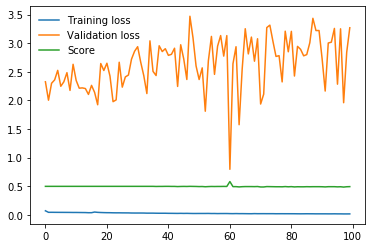

In [51]:
plt.plot(train_losses, label = 'Training loss')
plt.plot(validation_losses, label = 'Validation loss')
plt.plot(scores, label = 'Score')
plt.legend(frameon = False)

In [52]:
weights = df_train['LABEL'].value_counts(normalize = True)
modelo = Perceptron()
weights  = torch.tensor([weights[1], weights[0]])
criterion = torch.nn.CrossEntropyLoss(weights)
optimizer = torch.optim.Adam(modelo.parameters(), lr = learning_rate)

In [53]:
train_losses, validation_losses, scores = train(modelo, 'perceptron_adam_01', criterion, optimizer, epochs, alpha, beta,
                                                df_train, df_validation)

Score 0.4965585172176361 at epoch 0
New model saved
Matriz de confusión:
			Predicciones
Valor real	Negativos	Positivos
Negativos	1010		0
Positivos	7		0

Acierto: 0.9931170344352722 Sensibilidad: 0.0 Especificidad: 1.0 Score: 0.4965585172176361
Epoch: 0 Train loss 0.1687681053668677 Validation loss 1.8880730867385864
Score 0.4965585172176361 at epoch 1
Epoch: 1 Train loss 0.044770306584720455 Validation loss 2.320967674255371
Score 0.4965585172176361 at epoch 2
Epoch: 2 Train loss 0.043790769224748456 Validation loss 2.346316337585449
Score 0.4965585172176361 at epoch 3
Epoch: 3 Train loss 0.04375614605979028 Validation loss 2.333888053894043
Score 0.4965585172176361 at epoch 4
Epoch: 4 Train loss 0.04375353905324268 Validation loss 2.406552791595459
Score 0.4965585172176361 at epoch 5
Epoch: 5 Train loss 0.04375519189315434 Validation loss 2.4175524711608887
Score 0.4965585172176361 at epoch 6
Epoch: 6 Train loss 0.04375667422586544 Validation loss 2.4329745769500732
Score 0.496558517

KeyboardInterrupt: 